In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras
import tensorflow as tf
import PIL

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train

,label,latitude,longitude,year,example_path
0,0,-2.051853,111.826093,2001,train_test_data/train/1297.png
1,2,-1.989349,105.309496,2013,train_test_data/train/1199.png
2,0,1.223256,100.702217,2014,train_test_data/train/1348.png
3,0,-2.342948,103.890226,2008,train_test_data/train/2214.png
4,0,-0.126555,101.758175,2011,train_test_data/train/2220.png
...,...,...,...,...,...
1709,0,3.819464,117.636112,2016,train_test_data/train/550.png
1710,0,-1.809594,111.531951,2005,train_test_data/train/2264.png
1711,1,0.443397,112.200163,2012,train_test_data/train/1486.png
1712,2,-1.978349,101.970148,2012,train_test_data/train/1170.png


In [78]:
img = cv2.imread("train_test_data/train/1348.png")

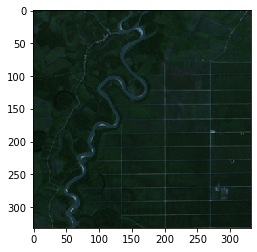

In [79]:
from matplotlib import pyplot as plt
plt.imshow(img, interpolation='nearest')
plt.show()

In [80]:
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
img_aug = cv2.filter2D(img, -1, kernel)

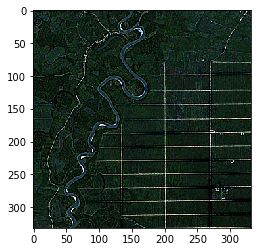

In [81]:
from matplotlib import pyplot as plt
plt.imshow(img_aug, interpolation='nearest')
plt.show()

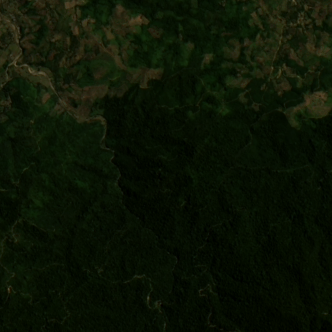

In [8]:
from PIL import Image

Image.open(train[train['label'] == 0].sample()['example_path'].iloc[0])

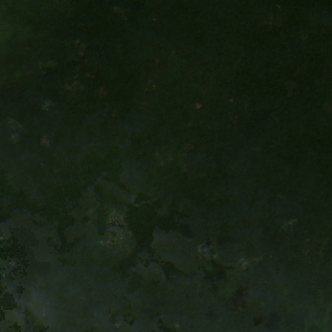

In [9]:
Image.open(train[train['label'] == 1].sample()['example_path'].iloc[0])

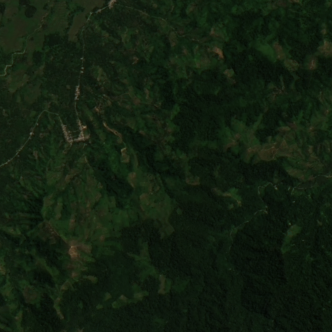

In [10]:
Image.open(train[train['label'] == 2].sample()['example_path'].iloc[0])

In [58]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, test_size=0.2, random_state=42)

In [59]:
train0 = train[train["label"] == 0]
train1 = train[train["label"] == 1]
train2 = train[train["label"] == 2]

In [60]:
#train_set = tf.data.Dataset.from_tensor_slices((train["example_path"],train["label"]))
#valid_set = tf.data.Dataset.from_tensor_slices((valid["example_path"],valid["label"]))

In [61]:
BUFFER_SIZE = 10000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

ds0 = make_ds(train0["example_path"],train0["label"])
ds1 = make_ds(train1["example_path"],train1["label"])
ds2 = make_ds(train2["example_path"],train2["label"])

train_ds = tf.data.Dataset.sample_from_datasets([ds0, ds1, ds2], weights=[0.34, 0.33, 0.33])

In [62]:
valid0 = valid[valid["label"] == 0]
valid1 = valid[valid["label"] == 1]
valid2 = valid[valid["label"] == 2]

In [63]:
dds0 = make_ds(valid0["example_path"],valid0["label"])
dds1 = make_ds(valid1["example_path"],valid1["label"])
dds2 = make_ds(valid2["example_path"],valid2["label"])

valid_ds = tf.data.Dataset.sample_from_datasets([dds0, dds1, dds2], weights=[0.34, 0.33, 0.33])

In [64]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

def kernel_f(image):
    image = tf.make_ndarray(image)
    image = cv2.filter2D(image, -1, kernel)
    image = tf.convert_to_tensor(image)
    return image

def preprocess(image, label):
    print(image)
    image = tf.io.read_file(image)
    image = tf.io.decode_png(image, channels=3,dtype=tf.dtypes.uint16)
    image = tf.cast(image,dtype=tf.float64)
    image = random_crop(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    resized_image = tf.image.resize(image, [256, 256])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    print(type(final_image), type(label))
    return final_image, label

In [65]:
batch_size = 32
train_set = train_ds.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_set = valid_ds.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Tensor("args_0:0", shape=(), dtype=string)
<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'>
Tensor("args_0:0", shape=(), dtype=string)
<class 'tensorflow.python.framework.ops.Tensor'> <class 'tensorflow.python.framework.ops.Tensor'>


In [31]:
dataset_size = int(len(train. index))

In [32]:
num_classes = 3

model = keras.Sequential([
  keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(num_classes)
])

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_set,
steps_per_epoch=int(0.75 * dataset_size / batch_size),
validation_data=valid_set,
validation_steps=int(0.15 * dataset_size / batch_size),
epochs=100)

Epoch 1/100
25/25 [==============================] - 11s 263ms/step - loss: 90.2072 - accuracy: 0.3413 - val_loss: 1.5237 - val_accuracy: 0.3750
Epoch 2/100
22/25 [=========================>....] - ETA: 0s - loss: 1.1878 - accuracy: 0.3182

KeyboardInterrupt: 

In [ ]:
dataset_size = int(len(train. index))

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(weights="imagenet",
include_top=False, input_shape=(224, 224, 3))

flattened = tf.keras.layers.Flatten()(base_model.output)

fc1 = tf.keras.layers.Dense(128, activation='relu', name="AddedDense1")(flattened)

fc2 = tf.keras.layers.Dense(3, activation='softmax', name="AddedDense3")(fc1)

model = tf.keras.models.Model(inputs=base_model.input, outputs=fc2)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
metrics=("accuracy"))
history = model.fit(train_set,
steps_per_epoch=int(0.75 * dataset_size / batch_size),
validation_data=valid_set,
validation_steps=int(0.15 * dataset_size / batch_size),
epochs=50)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
dataset_size = int(len(train. index))

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
metrics=("accuracy"))
history = model.fit(train_set,
steps_per_epoch=int(0.75 * dataset_size / batch_size),
validation_data=valid_set,
validation_steps=int(0.15 * dataset_size / batch_size),
epochs=50)

In [ ]:
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
metrics=["accuracy"])
history = model.fit(train_set,
steps_per_epoch=int(0.75 * dataset_size / batch_size),
validation_data=valid_set,
validation_steps=int(0.15 * dataset_size / batch_size),
epochs=10)